# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [3]:
from sklearn.base import BaseEstimator
class GradientBoosting(BaseEstimator):
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma_list = []
        self.trees = []
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        self.cumsum = np.zeros_like(y)
        for _ in range(self.n_estimators):
            y_new = y - self.cumsum
            self.cumsum += self._fit_predict_tree(x, y, y_new)
        return

    def _fit_predict_tree(self, x, y, y_new):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y_new)
        self.trees.append(tree)
        bn = tree.predict(x)
        def func(g):
            val = mean_squared_error(y, self.cumsum + g * bn)
            return val
        res = minimize(func, 1)
        self.gamma = res.x
        self.gamma_list.append(self.gamma)
        return self.gamma * self.learning_rate * tree.predict(x)

    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = self.learning_rate * np.sum([tree.predict(x) * gamma for tree, gamma in zip(self.trees, self.gamma_list)], axis=0)
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [6]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred)

25.806326618670013

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = {'n_estimators':[1, 5, 10, 50, 100, 300, 450, 600, 800, 1000],
              'max_depth':[1, 2, 4, 10, 20]}
gb = GradientBoosting(n_estimators=30, max_depth=None)
grid = GridSearchCV(gb, parameters, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoosting(max_depth=None, n_estimators=30),
             param_grid={'max_depth': [1, 2, 4, 10, 20],
                         'n_estimators': [1, 5, 10, 50, 100, 300, 450, 600, 800,
                                          1000]},
             scoring='neg_mean_squared_error')

In [8]:
print('best params: ', grid.best_params_)
print('best score = ', grid.best_score_)

best params:  {'max_depth': 4, 'n_estimators': 300}
best score =  -8.823151910981865


In [9]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=800, max_depth=4)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred)

14.840284588187973

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [10]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [11]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [12]:
!pip install xgboost

In [14]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = pd.get_dummies(train.drop(columns=["dep_delayed_15min"]))
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
# X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.7442334411934898

In [17]:
%%time
parameters = {
    'max_depth': [5, 6],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.3],
}
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 2,
    verbose=True
)
grid_search.fit(X_train_part, y_train_part)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Wall time: 16min 47s


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.1, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=5, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                           

In [18]:
print('best params: ', grid_search.best_params_)
print('best score = ', grid_search.best_score_)

best params:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
best score =  0.7293823437734009


In [19]:
xgb_model = XGBClassifier(learning_rate= 0.1, max_depth= 6, n_estimators= 300)
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.7476423389809922

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [73]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [272]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.current = 0

        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        clusters = [0 for _ in range(X.shape[0])] # 0 - не просмотренная точка

        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        for i in range(X.shape[0]):
            if clusters[i] != 0:
                continue
            
            # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
            neighbours = self.range_query(X[i], X, clusters)

            # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
            # (однако она ещё может попасть в какой-то иной кластер)
            if len(neighbours) < self.min_samples:
                clusters[i] = -1
            else:
                # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
                self.current += 1
                self.grow_cluster(X[i], neighbours, clusters, X)
            
        return clusters

    def grow_cluster(self, point, neighbours, clusters, X):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        i = 0
        while i < len(neighbours):
            nextPoint = neighbours[i]
            if clusters[nextPoint] == -1:
                clusters[nextPoint] = self.current

            elif clusters[nextPoint] == 0:
                clusters[nextPoint] = self.current
                nextNeighbors = self.range_query(X[nextPoint], X, clusters)

                if len(nextNeighbors) >= self.min_samples:
                    # print('Добавляем соседей')
                    # print(neighbours)
                    neighbours = neighbours + nextNeighbors
                    # print(neighbours)
            i += 1
        """
        plt.scatter(X[:,0], X[:,1], c=clusters)
        plt.show()
        for elem in neighbours:
            if clusters[elem] == -1:
                clusters[elem] = self.current

            elif clusters[elem] == 0:
                clusters[elem] = self.current
                nextNeighbors = self.range_query(point, X, clusters)

                if len(nextNeighbors) >= self.min_samples:
                    print('Добавляем соседей')
                    print(neighbours)
                    neighbours = neighbours + nextNeighbors
                    print(neighbours)
        """
        return

    def range_query(self, point, X, clusters):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        neighbours = []
        for i in range(X.shape[0]):
            if self.dist(point, X[i]) <= self.eps:
                neighbours.append(i)
        
        return neighbours
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        return distance.cdist(np.array([a]), np.array([b]), 'euclidean')
        

Проверим себя на простом примере:

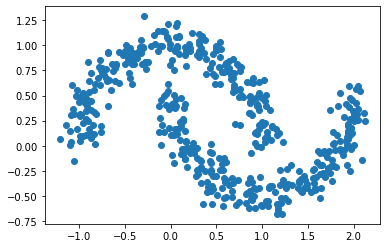

In [273]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

Референс:

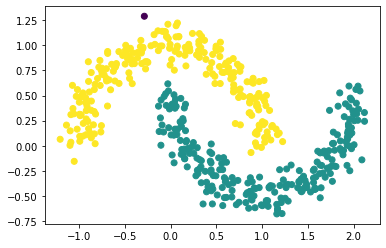

In [274]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

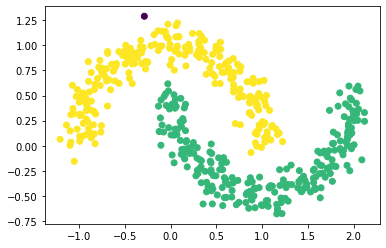

In [275]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



Или хотя бы что-нибудь такое: 

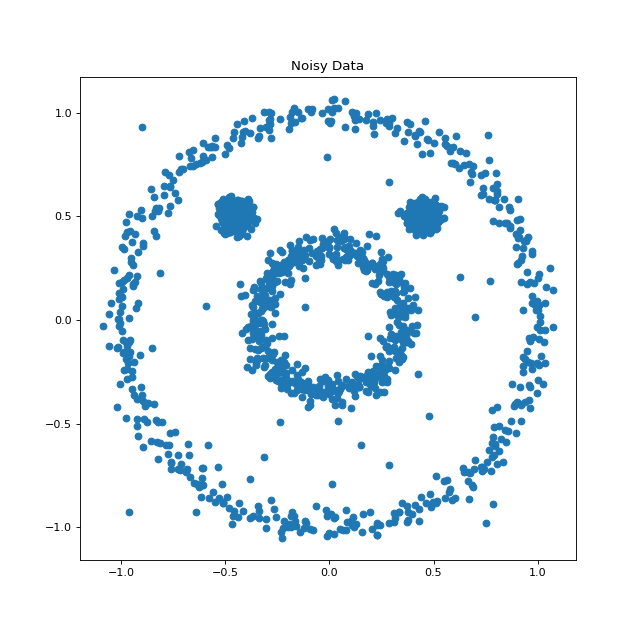

In [279]:
dct = {"x":[1.463,1.815,2.037,2.481,2.963,3.296,3.519,3.815,4.148,4.519,4.741,5.037,5.407,5.704,6.148,6.852,7.407,8,8.667,9.407,10.074,10.741,11.444,12.148,12.852,13.704,15.111,16.481,17.593,18.481,19.185,19.889,20.444,21.037,21.593,22,22.333,22.741,23.074,23.296,23.667,23.963,24.259,24.593,24.889,25,25.222,25.519,25.778,26,26.333,26.593,26.741,26.926,27.148,27.37,27.593,27.667,27.889,28.111,28.5],"y":[0.716,1.063,1.452,2.045,2.597,2.924,3.252,3.62,3.845,4.274,4.581,4.908,5.194,5.501,5.951,6.442,6.933,7.362,7.73,8.221,8.569,8.875,9.121,9.346,9.448,9.611,9.693,9.55,9.346,9.08,8.855,8.487,8.241,7.894,7.546,7.26,6.973,6.728,6.442,6.237,5.951,5.644,5.419,5.153,4.888,4.601,4.417,4.11,3.804,3.517,3.292,3.006,2.699,2.474,2.229,1.963,1.779,1.554,1.309,0.9,0.675]}

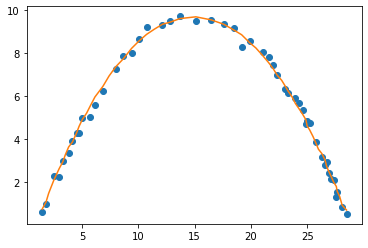

In [306]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import random

def random_line(data, sigma, size=10):
    data = np.array(random.sample(data, size))
    xdata = data[:, 0]
    ydata = data[:, 1]
    # Generate normally distributed random error ~ N(0, sigma**2)
    errors = scipy.stats.norm.rvs(loc=0, scale=sigma, size=size)
    ydata = ydata + errors
    return xdata, ydata

data = list(zip(dct['x'], dct['y']))
xs, ys = random_line(data, 0.2, size=50)

# Plot to see how closely the values fit the 
#   original line
fig, ax = plt.subplots()
ax.plot(xs, ys, 'o')
ax.plot(dct['x'], dct['y'])

In [481]:
def make_meme(path, eps):
    im = Image.open(path)
    width, height = im.size
    im = im.resize((width // 5, height // 5))
    im = im.quantize(colors=2,method=2)
    mas = np.array(im)
    total = []
    for i in range(mas.shape[1]):
        for j in range(mas.shape[0]):
            if mas[j][i]:
                total.append([i / mas.shape[1], (mas.shape[0] - j) / mas.shape[0]])
    total = np.array(total)
    x = total[:, 0]
    y = total[:, 1]
    # fig, ax = plt.subplots()
    # ax.plot(x, y, 'o')
    clusters = dbscan(eps=eps, min_samples=10).fit_predict(total)
    plt.scatter(total[:,0], total[:,1], c=clusters)
    plt.show()

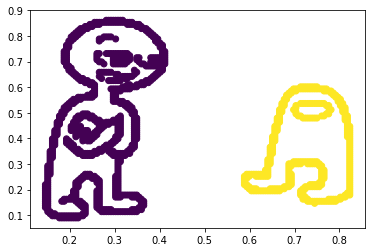

In [482]:
make_meme('sus.jpg', 0.1)

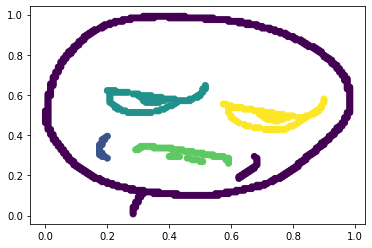

In [483]:
make_meme('meme.jpg', 0.06)


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [484]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 5 ms


In [485]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 4.23 s


ну как видно все шикарно

## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

In [512]:
data = np.array(train[['Distance', 'DepTime']])
clusters = DBSCAN(eps=200, min_samples=100).fit_predict(data)
plt.scatter(data[:,0], data[:,1], c=clusters)
plt.show()
set(clusters)

{-1}

ну так, средненько, где-то 8

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

In [513]:
# не хватает памяти, поэтому чуть обрежем датасет
data = data[:len(data) // 4]

In [ ]:
eps_list = [200, 1000, 2500]
min_samples = [100, 5000, 20000]
fig, axs = plt.subplots(3, 3, figsize=(15,15))
for i in range(3):
    for j in range(3):
        clusters = DBSCAN(eps=eps_list[i], min_samples=min_samples[j]).fit_predict(data)
        axs[i, j].scatter(data[:,0], data[:,1], c=clusters)
        axs[i, j].set_title(f"eps={eps_list[i]} min_samples={min_samples[j]}")

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [ ]:
# your code here  ¯\_(ツ)_/¯


__Ответ:__

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

**+0.1 балла** за смешной мем по машинному обучению

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.